# Paper Replicating

## 0.Get Setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 40.21 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get Data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2.Create Datasets and DataLoaders

### 2.1 Create Transforms

In [5]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### 2.2 Create dataloaders

In [6]:
# Create a batch size of 32
# Paper uses 4096 , our hardware cant handle
# Later can be upgraded

BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

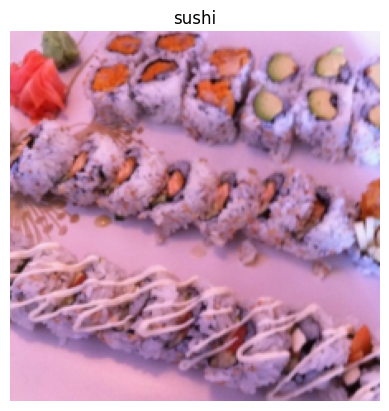

In [8]:
# Plot the image
import matplotlib.pyplot as plt

# Channels at the end
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

## 3.Replicating ViT : Overview

## 4.Equation 1: Split data into patches and creating the class, position and patch embedding

### 4.1 Calculating patch embedding input and output shapes by hand

In [9]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate number of patches
number_of_patches = int((height * width )/ (patch_size **2))
number_of_patches

196

In [10]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image ): {embedding_layer_input_shape}")
print(f"Output Shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image ): (224, 224, 3)
Output Shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

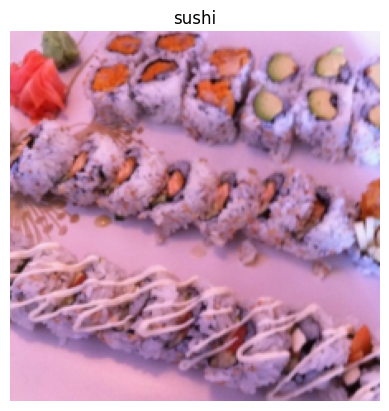

In [11]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

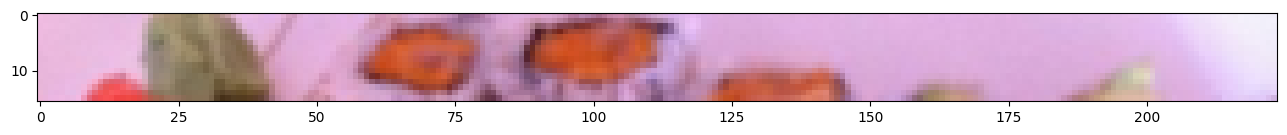

In [12]:
# get the top row of the image
# Convert to H * W  * C
image_permuted = image.permute(1,2,0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size , patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


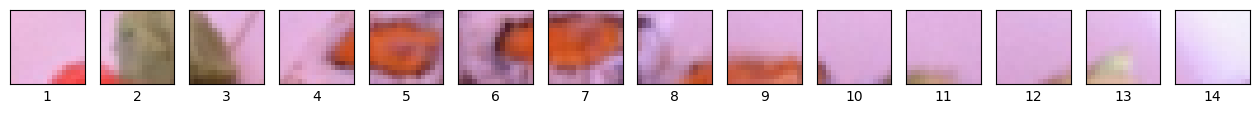

In [13]:
# Setup code to plot top row as patches
img_size = 224
patch_size =  16
num_patches = img_size / patch_size
# image size must be divisible by patch size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")



# create a series of subplots
fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size,  # One column per patch
    sharex = True,
    sharey = True,
    figsize = (patch_size, patch_size)
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


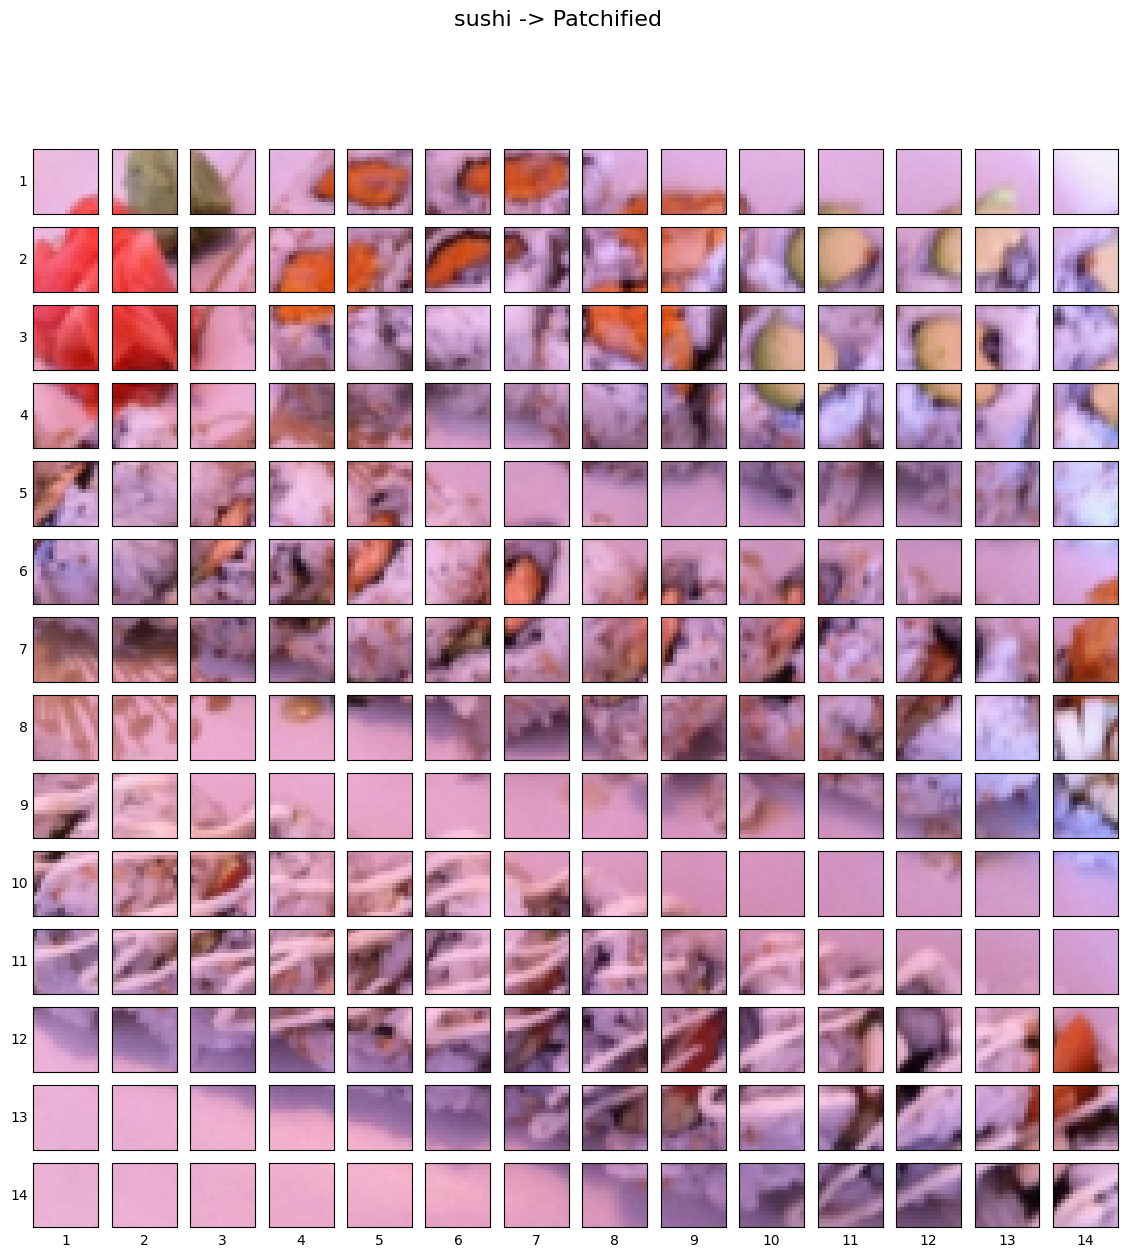

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

In [16]:
# Create conv2d layer to turn image into patches of learnable feature params

from torch import nn

# set the patch size
patch_size = 16

# create a conv2d layers
conv2d = nn.Conv2d(
    in_channels = 3,
    out_channels = 768,
    kernel_size = patch_size,
    stride = patch_size,
    padding = 0
)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

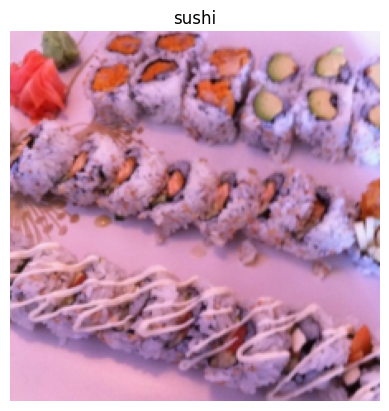

In [17]:
# view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
# pass the image through conv2d

# Add batch dimension
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [637, 385, 261, 360, 146]


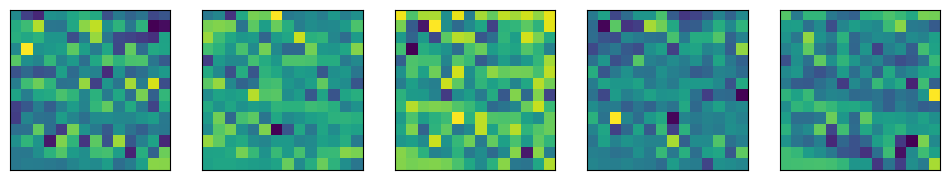

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.7967, -0.5226, -0.6381, -0.6388, -0.5360, -0.4009, -0.4164,
           -0.6603, -0.7196, -0.7140, -0.7368, -0.7212, -0.7686, -0.8342],
          [-0.6253, -0.4872, -0.3673, -0.5106, -0.5867, -0.3314, -0.5345,
           -0.6099, -0.5305, -0.5329, -0.4984, -0.5859, -0.6500, -0.7740],
          [-0.4678, -0.4606, -0.6168, -0.5066, -0.5093, -0.6618, -0.6786,
           -0.4380, -0.5567, -0.5083, -0.6732, -0.5412, -0.6785, -0.6739],
          [-0.6271, -0.5168, -0.6661, -0.5085, -0.4421, -0.4103, -0.4536,
           -0.6116, -0.3932, -0.4543, -0.5047, -0.5112, -0.6451, -0.4965],
          [-0.5429, -0.6390, -0.5519, -0.7244, -0.5421, -0.7062, -0.7085,
           -0.5634, -0.5948, -0.4156, -0.4418, -0.4099, -0.5281, -0.7735],
          [-0.4811, -0.5689, -0.4485, -0.4642, -0.6389, -0.6006, -0.4629,
           -0.6103, -0.5742, -0.5112, -0.5273, -0.6643, -0.6826, -0.7081],
          [-0.3569, -0.2458, -0.4554, -0.4176, -0.5270, -0.4947, -0.5401,
           -0.4389, -0.5334, -0.

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [22]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


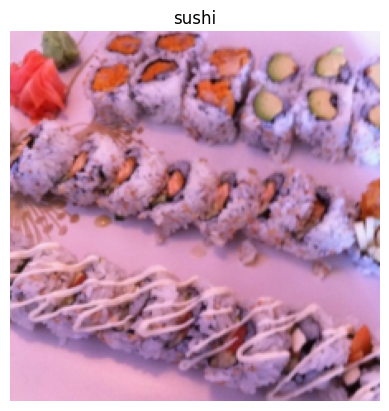

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


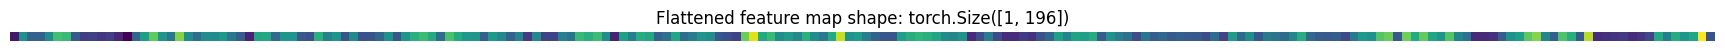

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.7967, -0.5226, -0.6381, -0.6388, -0.5360, -0.4009, -0.4164, -0.6603,
          -0.7196, -0.7140, -0.7368, -0.7212, -0.7686, -0.8342, -0.6253, -0.4872,
          -0.3673, -0.5106, -0.5867, -0.3314, -0.5345, -0.6099, -0.5305, -0.5329,
          -0.4984, -0.5859, -0.6500, -0.7740, -0.4678, -0.4606, -0.6168, -0.5066,
          -0.5093, -0.6618, -0.6786, -0.4380, -0.5567, -0.5083, -0.6732, -0.5412,
          -0.6785, -0.6739, -0.6271, -0.5168, -0.6661, -0.5085, -0.4421, -0.4103,
          -0.4536, -0.6116, -0.3932, -0.4543, -0.5047, -0.5112, -0.6451, -0.4965,
          -0.5429, -0.6390, -0.5519, -0.7244, -0.5421, -0.7062, -0.7085, -0.5634,
          -0.5948, -0.4156, -0.4418, -0.4099, -0.5281, -0.7735, -0.4811, -0.5689,
          -0.4485, -0.4642, -0.6389, -0.6006, -0.4629, -0.6103, -0.5742, -0.5112,
          -0.5273, -0.6643, -0.6826, -0.7081, -0.3569, -0.2458, -0.4554, -0.4176,
          -0.5270, -0.4947, -0.5401, -0.4389, -0.5334, -0.5820, -0.4534, -0.2681,
          -0.509

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

1. Create a class 'PatchEmbedding'
2. Initialize it with appropriate hyperparameters
3. Create a layer to turn an image in to embedding patches
4. Create a layer to flatten the feature maps of output layer
5. Define forward function for forward computation
6. Make sure output layer reflect the required shape of patch embedding

In [27]:
# 1. Create a class
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate params
  def __init__(self,
               in_channels : int = 3,
               patch_size : int = 16,
               embedding_dim : int = 768
               ):
    super().__init__()
    self.patch_size = patch_size
    # 3. Create layer to turn image into embedidng patches
    self.patcher  = nn.Conv2d(
                              in_channels = in_channels,
                              out_channels = embedding_dim,
                              kernel_size = patch_size,
                              stride = patch_size,
                              padding = 0
                            )

    # 4. Create llayer to flatten the feature maps
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  # 5. Define a forward method to define the forward computing steps
  def forward(self, x):
    # Create assertion to check that inputs are correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [29]:
rand_img_tensor = torch.randn(1,3, 224, 224)
rand_img_tensor_bad = torch.randn(1,3, 250, 250)

#patchify(rand_img_tensor_bad)


### 4.6 Creating class token embedding

In [30]:
# get the batch size and embedding dimensions
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [31]:
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                                      requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [32]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [33]:
# Add the class token embedding to the front of patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim =1) # nunber of patches dimension
# View the patch embedding and patch embedding shape
print(patch_embedded_image_with_class_embedding)
print(f"Patch embedding shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9959,  1.4136,  0.3723,  ..., -0.7879,  0.3636, -0.9186],
         [-0.7967,  0.0517, -0.0866,  ...,  0.5974, -0.4813,  0.3286],
         [-0.4437,  0.0110, -0.0679,  ...,  0.3452, -0.4176,  0.3092],
         ...,
         [-0.6777,  0.2289, -0.0305,  ...,  0.2482, -0.1999,  0.1918],
         [-0.0666,  0.0204, -0.0965,  ...,  0.1247, -0.2337,  0.1355],
         [-0.6529,  0.1832, -0.1006,  ...,  0.5199, -0.1801,  0.0924]]],
       grad_fn=<CatBackward0>)
Patch embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding

In [34]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[-0.9959,  1.4136,  0.3723,  ..., -0.7879,  0.3636, -0.9186],
          [-0.7967,  0.0517, -0.0866,  ...,  0.5974, -0.4813,  0.3286],
          [-0.4437,  0.0110, -0.0679,  ...,  0.3452, -0.4176,  0.3092],
          ...,
          [-0.6777,  0.2289, -0.0305,  ...,  0.2482, -0.1999,  0.1918],
          [-0.0666,  0.0204, -0.0965,  ...,  0.1247, -0.2337,  0.1355],
          [-0.6529,  0.1832, -0.1006,  ...,  0.5199, -0.1801,  0.0924]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# calculate the number of patches
number_of_patches = int((height * width )/patch_size**2)

# Get the mebdding dimensions
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [36]:
# Add position embedding to patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[0.0041, 2.4136, 1.3723,  ..., 0.2121, 1.3636, 0.0814],
          [0.2033, 1.0517, 0.9134,  ..., 1.5974, 0.5187, 1.3286],
          [0.5563, 1.0110, 0.9321,  ..., 1.3452, 0.5824, 1.3092],
          ...,
          [0.3223, 1.2289, 0.9695,  ..., 1.2482, 0.8001, 1.1918],
          [0.9334, 1.0204, 0.9035,  ..., 1.1247, 0.7663, 1.1355],
          [0.3471, 1.1832, 0.8994,  ..., 1.5199, 0.8199, 1.0924]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"\nPatch embeddings, class token prepended and positional embeddings added shape: \n{patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[0.0041, 2.4136, 1.3723,  ..., 0.2121, 1.3636, 0.0814],
         [0.2033, 1.0517, 0.9134,  ..., 1.5974, 0.5187, 1.3286],
         [0.5563, 1.0110, 0.9321,  ..., 1.3452, 0.5824, 1.3092],
         ...,
         [0.3223, 1.2289, 0.9695,  ..., 1.2482, 0.8001, 1.1918],
         [0.9334, 1.0204, 0.9035,  ..., 1.1247, 0.7663, 1.1355],
         [0.3471, 1.1832, 0.8994,  ..., 1.5199, 0.8199, 1.0924]]],
       grad_fn=<AddBackward0>)

Patch embeddings, class token prepended and positional embeddings added shape: 
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together: from image to embedding

In [38]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of original imag tensor and get image dims
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input Image Shape : {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. PAss input image through ImageEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape : {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True
                           )

print(f"Class Token Embedding Shape : {class_token.shape}")


# 7. Prepend the class token to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch Embedding with class token shape : {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)


# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and Position Embedding shape : {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input Image Shape : torch.Size([1, 3, 224, 224])
Patch Embedding Shape : torch.Size([1, 196, 768])
Class Token Embedding Shape : torch.Size([1, 1, 768])
Patch Embedding with class token shape : torch.Size([1, 197, 768])
Patch and Position Embedding shape : torch.Size([1, 197, 768])


##5.Equation 2: Multi-Head Attention (MSA)

### 5.1 Layer Normalization Layer

**Normalization** - Make data have the same mean and same standard deviation

### 5.2 Replicating Equation 2 with PyTorch layers

In [39]:
class MultiHeadAttentionBlock(nn.Module):
  '''
  Creates a multi-head self attention block.

  '''
  def __init__(self,
               embedding_dim : int = 768,
               num_heads:int = 12, # Heads of self attentions
               attn_dropout:int = 0
               ):
    super().__init__()
    # create the norm layer {LN}
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True
                                                )

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output


In [40]:
# Create an instance of MSA Block
multihead_self_attention_block = MultiHeadAttentionBlock(
    embedding_dim=768,
    num_heads = 12,
    attn_dropout=0
)

# pass the patch and position image embedding sequence through MSA block
patched_image_though_MSA_block = multihead_self_attention_block(
    patch_and_position_embedding
)

print(f"Input shape of MSA Block : {patch_and_position_embedding.shape}")
print(f"Output shape of MSA Block: {patched_image_though_MSA_block.shape}")

Input shape of MSA Block : torch.Size([1, 197, 768])
Output shape of MSA Block: torch.Size([1, 197, 768])


## 6.Equation 3: Multilayer Perceptron (MLP)

In [41]:
class MLPBlock(nn.Module):
  def __init__(
      self,
      embedding_dim:int = 768,
      mlp_size:int = 3072,
      dropout:int = 0.1):

    super().__init__()

    # Create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)

    return x
    #

In [42]:
# Create an instance of mlp block
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size=3027,
                     dropout=0.1)

# pass output the MSA Block through MLP block
patched_image_through_mlp_block = mlp_block(patched_image_though_MSA_block)
print(f"Input shape of MLP block: {patched_image_though_MSA_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7.Create the Transformer Encoder

In [43]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int = 768,
               num_heads:int= 12,
               mlp_size:int = 3072,
               mlp_dropout:int = 0.1,
               attn_dropout:int = 0
               ):
    super().__init__()

    # Create MSA block (Eq 2)
    self.msa_block = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                                             num_heads = num_heads,
                                             attn_dropout = attn_dropout
                                             )

    # create MLP block (Eq 3)
    self.mlp_block = MLPBlock( embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                               dropout = mlp_dropout
                               )
  def forward(self, x):
    x = self.msa_block(x) + x # Residual connection for Eq 2
    x = self.mlp_block(x) + x # Residual connection for Eq 3
    return x

In [44]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttentionBlock (msa_block)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [45]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8.Putting it all together to create ViT

In [47]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [48]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [49]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT mode

In [50]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 9.Setting up training code for our ViT model

In [51]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## 10.Using a pretrained ViT from torchvision.models on the same dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [54]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 123MB/s]


In [55]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.3 Preparing data for the pretrained ViT model

In [56]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [57]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [58]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [59]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4 Train feature extractor ViT model

In [60]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


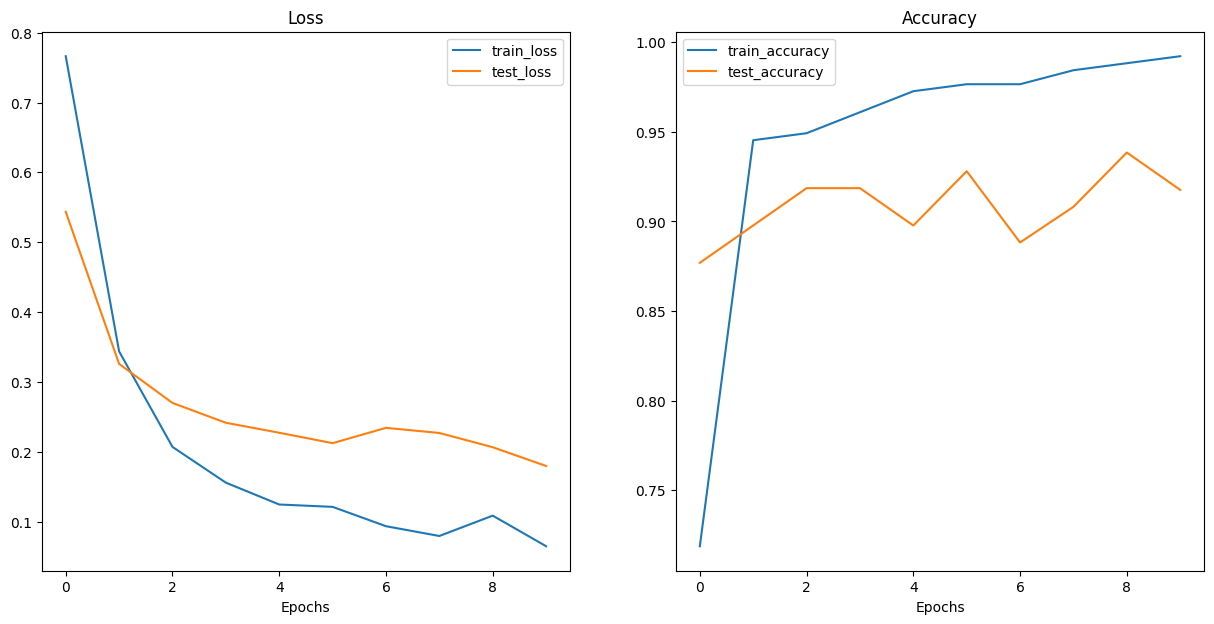

In [61]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save feature extractor ViT model and check file size

In [62]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [63]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Make predictions on a custom image

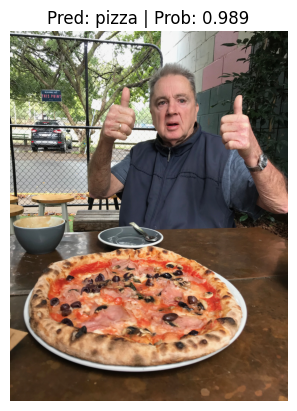

In [65]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)